In [113]:
# for colab
# !pip install xgboost==1.6.0 -q
!pip install catboost -q
# !pip install pandas==1.3.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 70000
sns.set(font_scale=1.3)
sns.set(style='white', font_scale=1.3)

In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode()

import plotly.io as pio
pio.renderers.default = "colab"

### Данные

In [8]:
train = pd.read_csv("./data/train.csv", engine='python', encoding='utf-8')
test = pd.read_csv("./data/test.csv")

In [9]:
train.head()

id        date city_name  store_id  category_id  product_id  price  \
0   1  2021-07-29    Москва       1.0          1.0         1.0   4.79   
1   2  2021-07-30    Москва       1.0          1.0         1.0   4.79   
2   3  2021-07-31    Москва       1.0          1.0         1.0   4.79   
3   4  2021-08-01    Москва       1.0          1.0         1.0   4.79   
4   5  2021-08-02    Москва       1.0          1.0         1.0   4.79   

                             weather_desc  humidity  temperature  pressure  \
0  переменная облачность, небольшой дождь   61.9375      23.1875  741.0000   
1  переменная облачность, небольшой дождь   70.2500      22.1875  740.3125   
2                   переменная облачность   52.6250      21.8125  741.6250   
3                облачно, небольшой дождь   87.4375      20.0625  743.3125   
4                   переменная облачность   66.1875      23.4375  739.6250   

   sales  
0   26.0  
1   37.0  
2   25.0  
3   26.0  
4   22.0

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453756 entries, 0 to 453755
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            453756 non-null  int64  
 1   date          453756 non-null  object 
 2   city_name     453756 non-null  object 
 3   store_id      453755 non-null  float64
 4   category_id   453755 non-null  float64
 5   product_id    453755 non-null  float64
 6   price         453755 non-null  float64
 7   weather_desc  453755 non-null  object 
 8   humidity      453755 non-null  float64
 9   temperature   453755 non-null  float64
 10  pressure      453755 non-null  float64
 11  sales         453755 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 41.5+ MB


In [11]:
train['mode'] = 'train'
test['mode'] = 'test'

df_init = pd.concat([train, test], axis=0, ignore_index=True)
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478592 entries, 0 to 478591
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            478592 non-null  int64  
 1   date          478592 non-null  object 
 2   city_name     478592 non-null  object 
 3   store_id      478591 non-null  float64
 4   category_id   478591 non-null  float64
 5   product_id    478591 non-null  float64
 6   price         478591 non-null  float64
 7   weather_desc  478591 non-null  object 
 8   humidity      478591 non-null  float64
 9   temperature   478591 non-null  float64
 10  pressure      478591 non-null  float64
 11  sales         453755 non-null  float64
 12  mode          478592 non-null  object 
dtypes: float64(8), int64(1), object(4)
memory usage: 47.5+ MB


In [12]:
num_features = ['store_id', 'category_id', 'product_id', 'humidity', 'temperature', 'pressure']
cat_features = ['city_name', 'weather_desc', 'mode']

target = ['sales']

Немного преобразуем признаки

In [13]:
# введём вместо даты день недели
date = pd.to_datetime(df_init['date'])
df_init.insert(loc=2, column='dayofweek', value=date.dt.dayofweek)

df_init.head()

id        date  dayofweek city_name  store_id  category_id  product_id  \
0   1  2021-07-29          3    Москва       1.0          1.0         1.0   
1   2  2021-07-30          4    Москва       1.0          1.0         1.0   
2   3  2021-07-31          5    Москва       1.0          1.0         1.0   
3   4  2021-08-01          6    Москва       1.0          1.0         1.0   
4   5  2021-08-02          0    Москва       1.0          1.0         1.0   

   price                            weather_desc  humidity  temperature  \
0   4.79  переменная облачность, небольшой дождь   61.9375      23.1875   
1   4.79  переменная облачность, небольшой дождь   70.2500      22.1875   
2   4.79                   переменная облачность   52.6250      21.8125   
3   4.79                облачно, небольшой дождь   87.4375      20.0625   
4   4.79                   переменная облачность   66.1875      23.4375   

   pressure  sales   mode  
0  741.0000   26.0  train  
1  740.3125   37.0  train  
2  741.6250   25.0  train  
3  743.3125   26.0  train  
4  739.6250   22.0  train

array([[<Axes: title={'center': 'store_id'}>,
        <Axes: title={'center': 'category_id'}>],
       [<Axes: title={'center': 'product_id'}>, <Axes: >]], dtype=object)

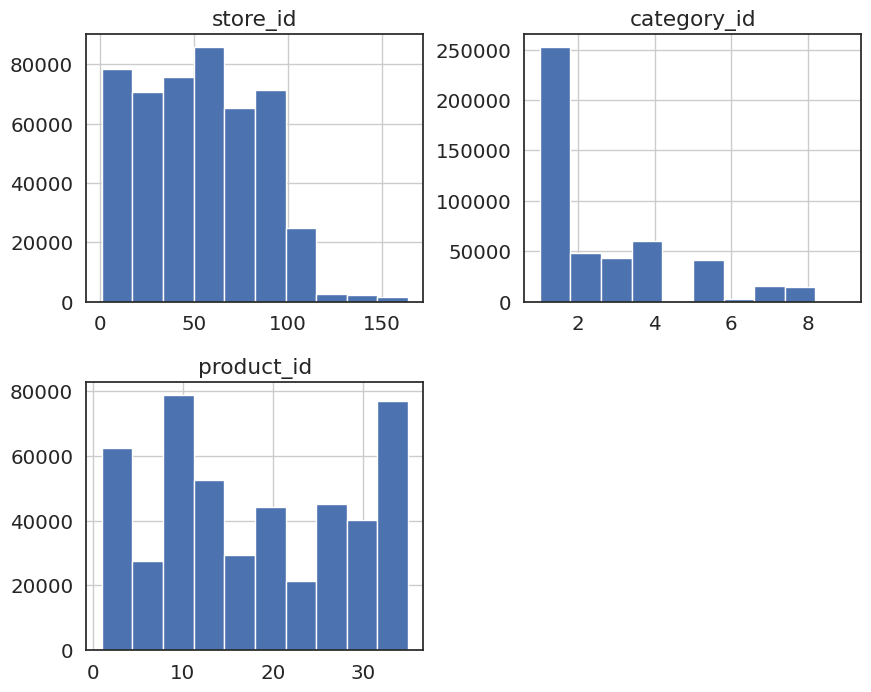

In [14]:
df_init[['store_id', 'category_id', 'product_id']].hist(figsize=(10,8))

У **categoty_id** виден выброс для "1". У остальных всё более-менее равномерно

<Axes: xlabel='dayofweek'>

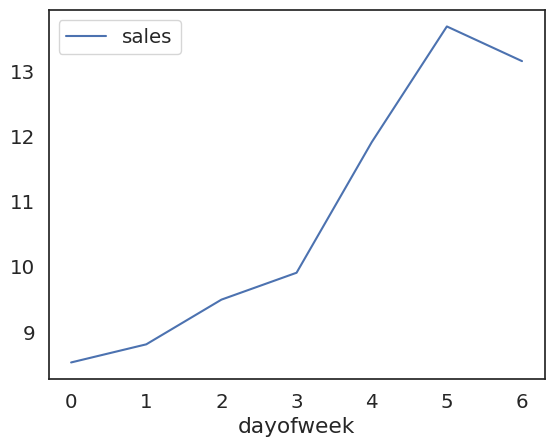

In [15]:
# видно, что к концу недели спрос выше
y = df_init[['dayofweek', 'sales']].groupby(by='dayofweek').mean()
y.plot()

In [16]:
group = df_init[['date', 'city_name', 'sales']].groupby(['date', 'city_name'], as_index=False).sum()
fig = px.line(group, x="date", y="sales", color='city_name', template='plotly_dark')
fig.update_layout(
    title={
        'text': "Количество заказов по городам",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Забавный факт: Продажи во всех городах падают 31 декабря))
Также видно, что колебания обусловлены днём недели

Ну и также подтверждается очевидный факт, что продажи зависят от города. Поэтому использовать это в качестве признака вполне разумно

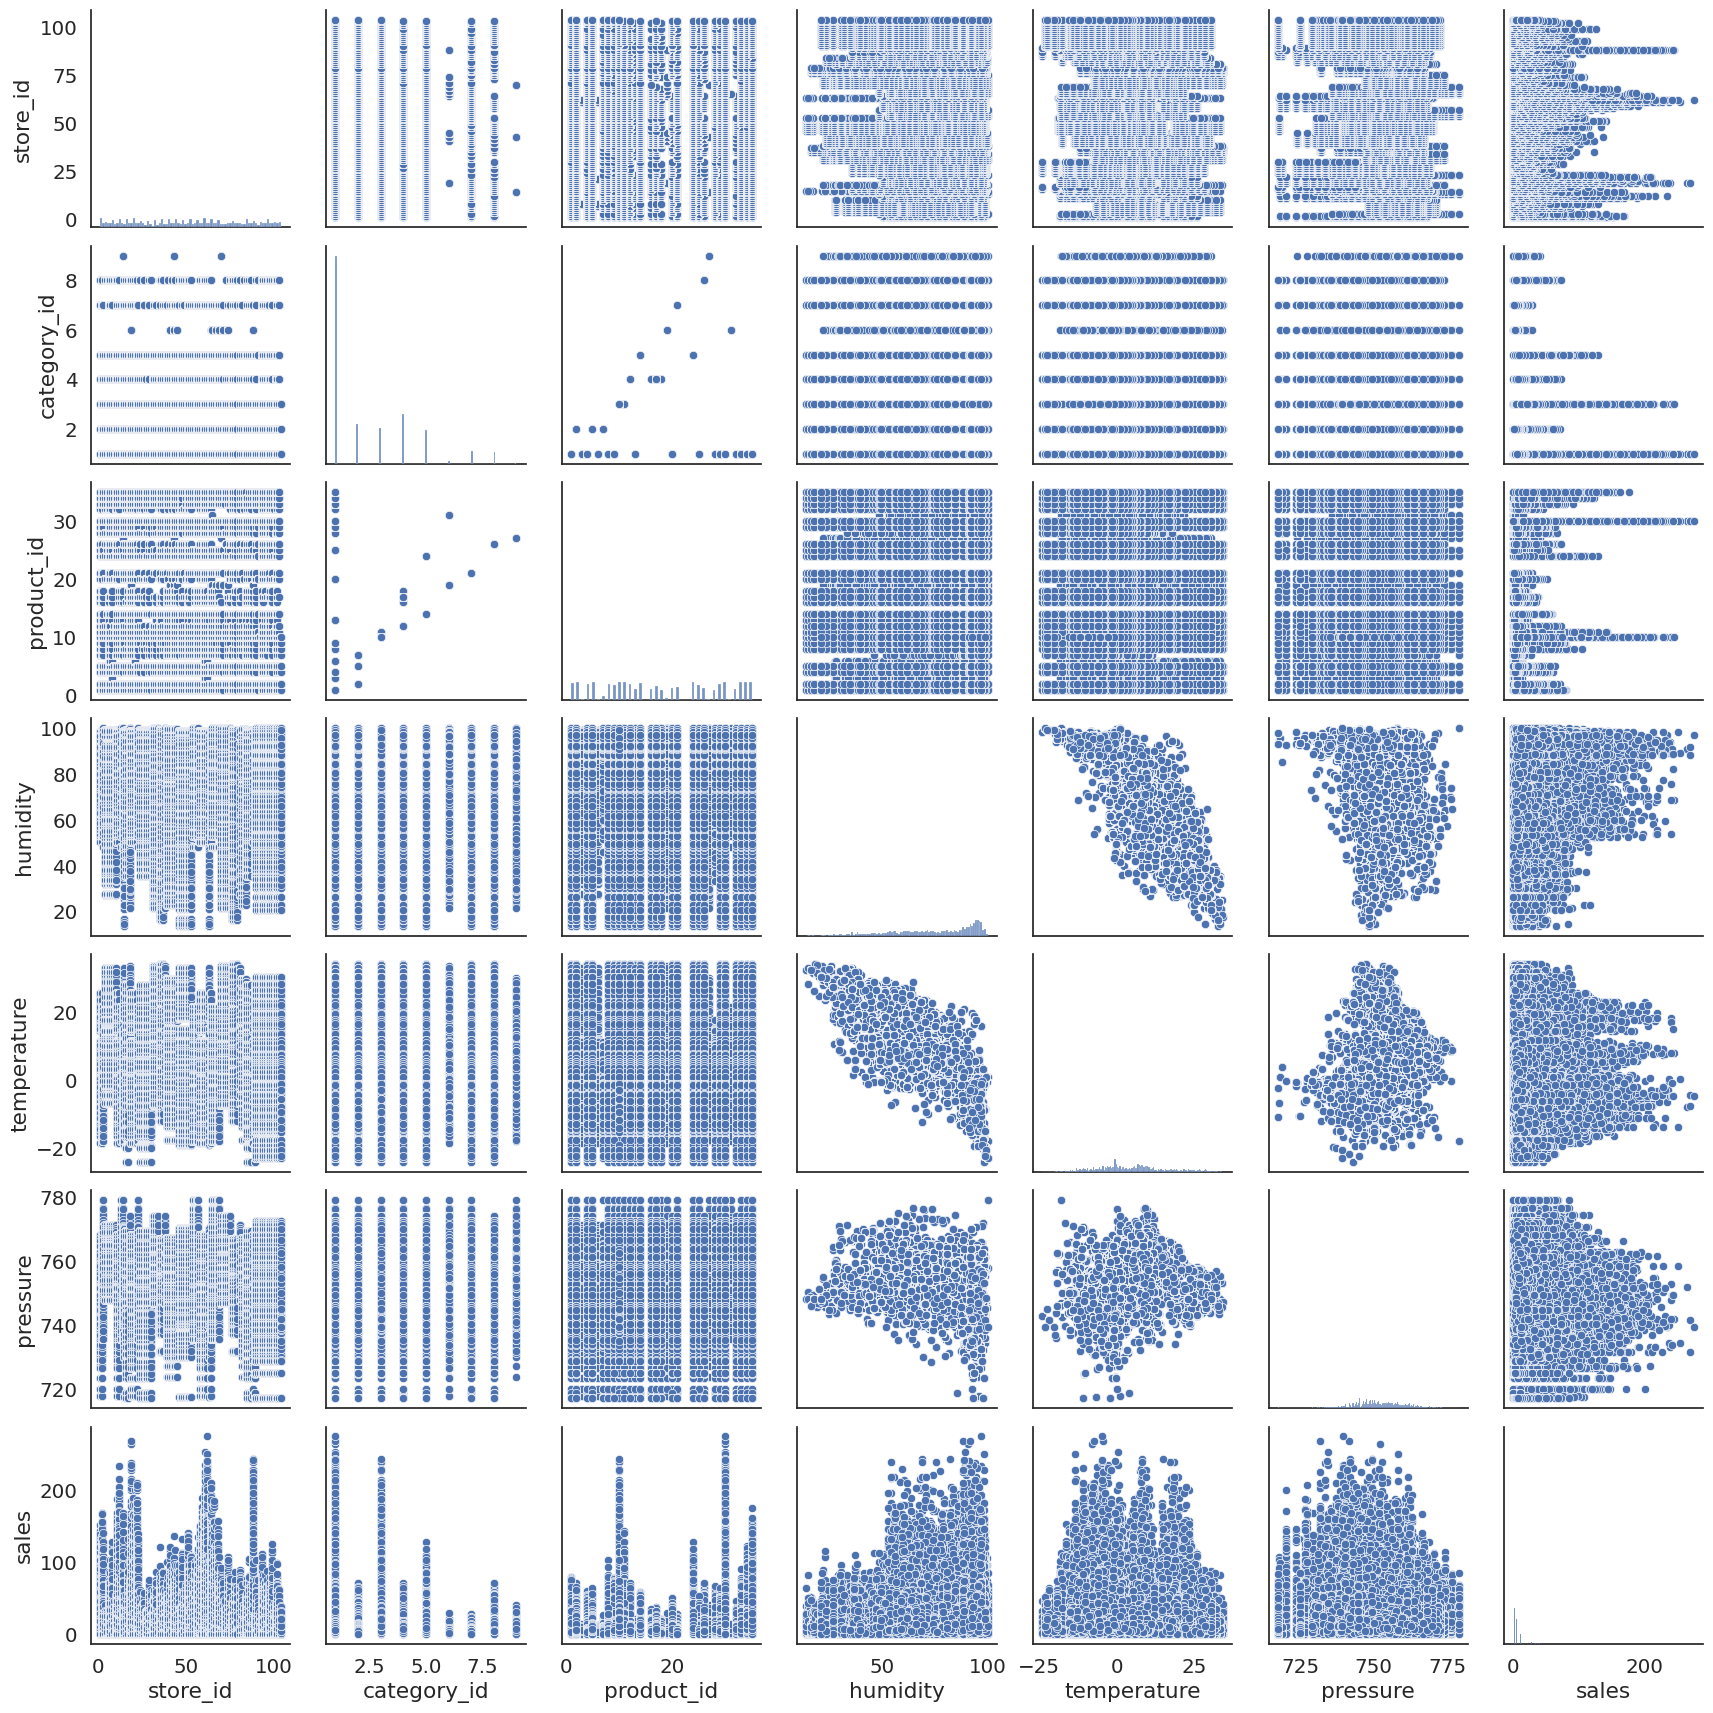

In [17]:
sns.pairplot(train[num_features + target])

Тут можно увидеть корреляции между погодными условиями, что логично.

Видно также, что при повышении влажности, достигается максимум по заказам, что интересно.

#### Модель

In [18]:
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

In [19]:
# Добавим лаговые фичи
# Количество заказов по дням до 3х недель (лаги на 7, 8, ..., 21 день)
group = df_init.groupby(['store_id', 'product_id'])
for i in range(7, 21):
    df_init[f'lag_day_{i}'] = group['sales'].shift(i)

df_init.sample(5)

id        date  dayofweek        city_name  store_id  category_id  \
267615  267616  2022-01-25          1           Москва      60.0          1.0   
397363  397364  2021-12-07          1           Казань      90.0          1.0   
213450  213451  2021-08-30          0           Самара      49.0          2.0   
13234    13235  2021-09-20          0  Санкт-Петербург       3.0          7.0   
342129  342130  2022-01-17          0        Волгоград      77.0          5.0   

        product_id  price                       weather_desc  humidity  ...  \
267615        28.0   3.83                            облачно   96.1250  ...   
397363        30.0   2.49                            облачно   84.4375  ...   
213450         5.0  11.25              переменная облачность   26.8125  ...   
13234         21.0  18.63                            облачно   62.0625  ...   
342129        24.0   2.52  облачно, без существенных осадков   91.3750  ...   

        lag_day_11  lag_day_12  lag_day_13 lag_day_14  lag_day_15  lag_day_16  \
267615        30.0        24.0        29.0        9.0        30.0        20.0   
397363        30.0        31.0        25.0       36.0        26.0        18.0   
213450         4.0         0.0         1.0        1.0         2.0         8.0   
13234          6.0         3.0         3.0        2.0         7.0         4.0   
342129         5.0         3.0         3.0        4.0         4.0         7.0   

        lag_day_17  lag_day_18  lag_day_19  lag_day_20  
267615        32.0        16.0        22.0        23.0  
397363        12.0        23.0        35.0        21.0  
213450         6.0         1.0         2.0         1.0  
13234          6.0         1.0         8.0         3.0  
342129         0.0         1.0         3.0         4.0  

[5 rows x 28 columns]

In [22]:
df_init.columns

Index(['id', 'date', 'dayofweek', 'city_name', 'store_id', 'category_id',
       'product_id', 'price', 'weather_desc', 'humidity', 'temperature',
       'pressure', 'sales', 'mode', 'lag_day_7', 'lag_day_8', 'lag_day_9',
       'lag_day_10', 'lag_day_11', 'lag_day_12', 'lag_day_13', 'lag_day_14',
       'lag_day_15', 'lag_day_16', 'lag_day_17', 'lag_day_18', 'lag_day_19',
       'lag_day_20'],
      dtype='object')

In [105]:
# one-hot-encoding
add_lags = True
train_features = ['dayofweek', 'city_name', 'store_id', 'category_id', 'product_id', 'price', 'weather_desc', 'humidity', 'temperature', 'pressure']

if add_lags:
    lags_features = ['lag_day_7', 'lag_day_14', 'lag_day_20']
else:
    lags_features = []

df = df_init[train_features + lags_features + target + ['id','mode']]

df = pd.concat((df, pd.get_dummies(df.city_name, prefix='city')), axis=1)
df = pd.concat((df, pd.get_dummies(df.weather_desc, prefix='wd')), axis=1)

train_df = df[df['mode']=='train'].copy()
test_df = df[df['mode']=='test'].copy()

In [106]:
train_df.columns

Index(['dayofweek', 'city_name', 'store_id', 'category_id', 'product_id',
       'price', 'weather_desc', 'humidity', 'temperature', 'pressure',
       'lag_day_7', 'lag_day_14', 'lag_day_20', 'sales', 'id', 'mode',
       'city_Волгоград', 'city_Воронеж', 'city_Екатеринбург', 'city_Каза',
       'city_Казань', 'city_Краснодар', 'city_Москва', 'city_Нижний Новгород',
       'city_Ростов-на-Дону', 'city_Самара', 'city_Санкт-Петербург',
       'wd_дождь', 'wd_дождь, гроза', 'wd_метель', 'wd_облачно',
       'wd_облачно, без существенных осадков', 'wd_облачно, небольшие осадки',
       'wd_облачно, небольшой дождь', 'wd_облачно, небольшой снег',
       'wd_осадки', 'wd_переменная облачность',
       'wd_переменная облачность, дождь',
       'wd_переменная облачность, небольшие осадки',
       'wd_переменная облачность, небольшой дождь',
       'wd_переменная облачность, небольшой снег', 'wd_снег', 'wd_ясно'],
      dtype='object')

In [92]:
num_features = ['price', 'humidity', 'temperature', 'pressure'] + lags_features
drop_features = ['city_name', 'mode', 'weather_desc', 'sales']
cat_features = list(set(train_df.columns) - set(drop_features) - set(num_features))

X = train_df[num_features+cat_features]
y = train_df[target]

# drop null
idx_null = np.where(y.isna())[0][0]
X.drop(idx_null, inplace=True)
y.drop(idx_null, inplace=True)

X_target = test_df[num_features+cat_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.columns

Index(['price', 'humidity', 'temperature', 'pressure', 'lag_day_7',
       'lag_day_14', 'lag_day_20', 'category_id', 'city_Екатеринбург',
       'wd_переменная облачность, дождь', 'city_Волгоград',
       'city_Нижний Новгород', 'wd_переменная облачность, небольшой снег',
       'wd_осадки', 'wd_дождь', 'wd_облачно, без существенных осадков',
       'store_id', 'wd_ясно', 'city_Санкт-Петербург', 'wd_облачно',
       'city_Москва', 'city_Самара', 'wd_облачно, небольшие осадки',
       'city_Казань', 'wd_облачно, небольшой снег', 'city_Ростов-на-Дону',
       'wd_снег', 'wd_переменная облачность, небольшие осадки', 'city_Каза',
       'dayofweek', 'wd_переменная облачность, небольшой дождь',
       'city_Краснодар', 'wd_дождь, гроза', 'wd_метель',
       'wd_переменная облачность', 'product_id', 'city_Воронеж',
       'wd_облачно, небольшой дождь'],
      dtype='object')

In [94]:
scaler = StandardScaler()

# категориальные фичи
X_train_cat = X_train[cat_features].values
X_test_cat = X_test[cat_features].values

# скалируем числовые фичи
X_train_num = X_train[num_features].copy()
X_test_num = X_test[num_features].copy()

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

# итоговые датасеты для обучения
X_train = pd.DataFrame(np.hstack((X_train_num, X_train_cat)), columns=num_features+cat_features)
X_test = pd.DataFrame(np.hstack((X_test_num, X_test_cat)), columns=num_features+cat_features)
X_train.head()

price  humidity  temperature  pressure  lag_day_7  lag_day_14  \
0  0.438401 -0.962036     0.332750  0.190816  -0.369585   -0.365893   
1 -0.521105  0.759481    -0.765816 -0.766067  -0.304673   -0.562691   
2 -0.760981 -1.077819     0.273514  1.679299   0.604093   -0.037898   
3  0.274583  0.744247     0.004257  0.622742  -0.499409   -0.300294   
4  0.327239 -0.401400     0.241203  1.147698  -0.564321   -0.562691   

   lag_day_20  category_id  city_Екатеринбург  \
0   -0.496825          1.0                0.0   
1   -0.696742          3.0                0.0   
2    0.502762          1.0                0.0   
3   -0.163629          1.0                0.0   
4   -0.696742          1.0                0.0   

   wd_переменная облачность, дождь  ...  city_Каза  dayofweek  \
0                              0.0  ...        0.0        1.0   
1                              0.0  ...        0.0        6.0   
2                              0.0  ...        0.0        4.0   
3                              0.0  ...        0.0        3.0   
4                              0.0  ...        0.0        2.0   

   wd_переменная облачность, небольшой дождь  city_Краснодар  wd_дождь, гроза  \
0                                        1.0             0.0              0.0   
1                                        0.0             0.0              0.0   
2                                        0.0             0.0              0.0   
3                                        0.0             0.0              0.0   
4                                        0.0             0.0              0.0   

   wd_метель  wd_переменная облачность  product_id  city_Воронеж  \
0        0.0                       0.0        32.0           0.0   
1        0.0                       0.0        11.0           0.0   
2        0.0                       0.0        35.0           0.0   
3        0.0                       1.0        29.0           0.0   
4        0.0                       1.0        13.0           0.0   

   wd_облачно, небольшой дождь  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  

[5 rows x 38 columns]

In [95]:
X_train.shape

(363004, 38)

In [96]:
# sampling
size = X_train.shape[0]
y_train.reset_index(drop=True,inplace=True)

df_processing = pd.concat([X_train, y_train], axis=1)
df_sample = df_processing.sample(size)
X_train_sample = df_sample[num_features+cat_features]
y_train_sample = df_sample[target]
df_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363004 entries, 0 to 363003
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   price                                       363004 non-null  float64
 1   humidity                                    363004 non-null  float64
 2   temperature                                 363004 non-null  float64
 3   pressure                                    363004 non-null  float64
 4   lag_day_7                                   349765 non-null  float64
 5   lag_day_14                                  336487 non-null  float64
 6   lag_day_20                                  325092 non-null  float64
 7   category_id                                 363004 non-null  float64
 8   city_Екатеринбург                           363004 non-null  float64
 9   wd_переменная облачность, дождь             363004 non-null  float64
 

In [97]:
X_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363004 entries, 25453 to 4012
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   price                                       363004 non-null  float64
 1   humidity                                    363004 non-null  float64
 2   temperature                                 363004 non-null  float64
 3   pressure                                    363004 non-null  float64
 4   lag_day_7                                   349765 non-null  float64
 5   lag_day_14                                  336487 non-null  float64
 6   lag_day_20                                  325092 non-null  float64
 7   category_id                                 363004 non-null  float64
 8   city_Екатеринбург                           363004 non-null  float64
 9   wd_переменная облачность, дождь             363004 non-null  float64

#### xgboost

In [98]:
%%time
# X_train_sample.dropna()
boosting_model = xgboost.XGBRegressor(n_estimators=300,
                                      max_depth=5,
                                      eta=0.05,
                                      n_jobs=-1
                                      #tree_method="hist",
                                      #eval_metric=mean_squared_error
                                      )


boosting_model.fit(X_train, y_train)

#y_train_predicted = boosting_model.predict_proba(X_train_sample)[:, 1]
#y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

CPU times: user 6min 31s, sys: 1.07 s, total: 6min 32s
Wall time: 3min 46s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [99]:
%%time
y_pred = boosting_model.predict(X_train)
y_pred_test = boosting_model.predict(X_test)

# print('MSE score using LogisticRegressionCV: {:.4f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE score on train: {:.4f}'.format(mean_absolute_error(y_train, y_pred)))
print('MAE score on test: {:.4f}'.format(mean_absolute_error(y_test, y_pred_test)))

MAE score on train: 3.8865
MAE score on test: 3.9354
CPU times: user 4.61 s, sys: 4.97 ms, total: 4.61 s
Wall time: 2.42 s


In [100]:
X_train.head()

price  humidity  temperature  pressure  lag_day_7  lag_day_14  \
0  0.438401 -0.962036     0.332750  0.190816  -0.369585   -0.365893   
1 -0.521105  0.759481    -0.765816 -0.766067  -0.304673   -0.562691   
2 -0.760981 -1.077819     0.273514  1.679299   0.604093   -0.037898   
3  0.274583  0.744247     0.004257  0.622742  -0.499409   -0.300294   
4  0.327239 -0.401400     0.241203  1.147698  -0.564321   -0.562691   

   lag_day_20  category_id  city_Екатеринбург  \
0   -0.496825          1.0                0.0   
1   -0.696742          3.0                0.0   
2    0.502762          1.0                0.0   
3   -0.163629          1.0                0.0   
4   -0.696742          1.0                0.0   

   wd_переменная облачность, дождь  ...  city_Каза  dayofweek  \
0                              0.0  ...        0.0        1.0   
1                              0.0  ...        0.0        6.0   
2                              0.0  ...        0.0        4.0   
3                              0.0  ...        0.0        3.0   
4                              0.0  ...        0.0        2.0   

   wd_переменная облачность, небольшой дождь  city_Краснодар  wd_дождь, гроза  \
0                                        1.0             0.0              0.0   
1                                        0.0             0.0              0.0   
2                                        0.0             0.0              0.0   
3                                        0.0             0.0              0.0   
4                                        0.0             0.0              0.0   

   wd_метель  wd_переменная облачность  product_id  city_Воронеж  \
0        0.0                       0.0        32.0           0.0   
1        0.0                       0.0        11.0           0.0   
2        0.0                       0.0        35.0           0.0   
3        0.0                       1.0        29.0           0.0   
4        0.0                       1.0        13.0           0.0   

   wd_облачно, небольшой дождь  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  

[5 rows x 38 columns]

In [111]:
df_test = df_init[df_init['mode']=='test']
df_test['prediction'] = boosting_model.predict(X_target)
prediction = df_test[['id', 'prediction']]
# prediction = pd.DataFrame({'id':test_df['id'].values, 'prediction':test_df['prediction'].values})
prediction.to_csv('prediction.csv', index=False, encoding='utf-8')

#### Catboost

In [114]:
from catboost import CatBoostRegressor

In [115]:
%%time
c_model=CatBoostRegressor(loss_function='MAE',
                          random_state=42,
                          silent=True,
                          #num_boost_round=1000,
                          n_estimators=2000,
                          max_depth=10)

c_model.fit(X_train_sample, y_train_sample,
            # cat_features=cat_features,
            use_best_model=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


CPU times: user 9min 29s, sys: 5.79 s, total: 9min 35s
Wall time: 6min 19s


In [116]:
c_model.best_score_

{'learn': {'MAE': 3.398121132549824}}

In [119]:
y_pred = c_model.predict(X_test)

print("MAE on train: {:.4f}".format(mean_absolute_error(y_pred, y_test)))

MAE on train: 3.5973


In [120]:
df_test['prediction'] = boosting_model.predict(X_target)
prediction = df_test[['id', 'prediction']]
# prediction = pd.DataFrame({'id':test_df['id'].values, 'prediction':test_df['prediction'].values})
prediction.to_csv('prediction.csv', index=False, encoding='utf-8')